# Proyecto Data Analytics
Prediccion de propiedades de catalizadores para la generación de hidrógeno usando redes neuronales de grafos.
## Fuente de datos
[Open Catalyst Proyect (OC22)](https://dl.fbaipublicfiles.com/opencatalystproject/data/is2res_train_val_test_lmdbs.tar.gz)

## Arquitecturas a probar
- Red Neuronal de Grafos Convolucional (GCN)
- Arquitectura Híbrida (GAT, GIN, Edge_Gated)

## Motivación
Hoy en día la generación de energía a partir del hidrógeno se ha vuelto cada vez más popular. Sin embargo la generación de este gas a travez de la electrólisis del agua ha demostrado ser muy costosa en términos energéticos por tanto para reducir la energía necesaria se requiere el uso de catalizadores.

Sin embargo, estos catalizadores principalmente compuestos por platino, entre otros metales preciosos lo que inviabiliza estas alternativas. Es por esto por lo que la investigación en uevos catalizadores es esencial para impulsar esta trancisión. Pero estas investigaciones a día de hoy pueden tomar entre 5 a 10 años debido a la cantidad de combinaciones de materiales que se pueden construir que alcanza el orden de $10^{10}$. Actualmente las propiedades de posibles candidatos a catalizadores pueden ser determinadas empelando técnicas teóricas como puede ser la palicación de la teoría de densidad funcional. Sin embargo, este método puede horas o días para cada una de las posibles estructuras, mientras que una red neuronal podría realizar predicciones similares en segundos. 

# Importar el dataset

In [4]:
# importar helpers necesarios
# lectura de lmdb
from helpers.utils import load_lmdb_data
# Creación de grafos
from helpers.data_loader import (AdvancedCatalystDataset, # with edge_attr
                                 CatalystDataset # without edge_attr
                                 )
# EDA helpers
import helpers.EDA as EDA
from collections import Counter
# Data Handeling
import pandas as pd
import numpy as np 
# Charts
import matplotlib.pyplot as plt
import seaborn as sns
from helpers.utils import plot_graphs_pyg
# models
from helpers.IS2RE_GCN import *
from helpers.hibridmodel import *
# training and evaluation
from helpers.utils import train_evaluate_epoch

In [2]:
path = '../data/raw/is2res_train_val_test_lmdbs/data/is2re/all/train/data.lmdb'
data = load_lmdb_data(path, 100)
data.head(1)

,x,edge_index,edge_attr,pos,norm,face,cell,atomic_numbers,natoms,cell_offsets,force,distances,fixed,sid,tags,y_init,y_relaxed,pos_relaxed
0,None,"[[69, 83, 75, 35, 43, 37, 39, 5, 56, 45, 58, 2...",None,"[[7.0255556, 0.0, 12.73459], [6.9654884, 10.95...",None,None,"[[[11.832515, 0.0, -0.026398], [-3.0482295, 16...","[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13....",86,"[[0, -1, 0], [0, 0, 0], [0, -1, 0], [0, -1, 0]...","[[0.07672916, 0.03236759, 0.5780765], [0.03831...","[2.811749, 2.811749, 2.811749, 2.8439174, 2.84...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...",2472718,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...",6.282501,-0.02555,"[[7.0255556, 0.0, 12.73459], [6.872939, 10.890..."


# Exploratory data analysys

In [3]:
# review data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x               0 non-null      object 
 1   edge_index      100 non-null    object 
 2   edge_attr       0 non-null      object 
 3   pos             100 non-null    object 
 4   norm            0 non-null      object 
 5   face            0 non-null      object 
 6   cell            100 non-null    object 
 7   atomic_numbers  100 non-null    object 
 8   natoms          100 non-null    int64  
 9   cell_offsets    100 non-null    object 
 10  force           100 non-null    object 
 11  distances       100 non-null    object 
 12  fixed           100 non-null    object 
 13  sid             100 non-null    int64  
 14  tags            100 non-null    object 
 15  y_init          100 non-null    float64
 16  y_relaxed       100 non-null    float64
 17  pos_relaxed     100 non-null    obje

In [4]:
# Count duplicate structures
data['sid'].value_counts().sum()

np.int64(100)

Text(0.5, 1.0, 'Distribución de números atómicos')

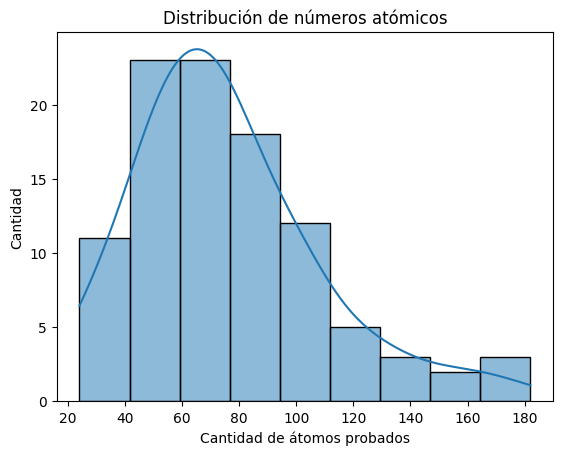

In [5]:
# verify max atom number
atom_counts = data['atomic_numbers'].apply(lambda x: len(x))

sns.histplot(atom_counts, kde=True)
plt.xlabel('Cantidad de átomos probados')
plt.ylabel('Cantidad')
plt.grid(False)
plt.title('Distribución de números atómicos')

In [6]:
list(atom_counts).index(min(list(atom_counts)))

82

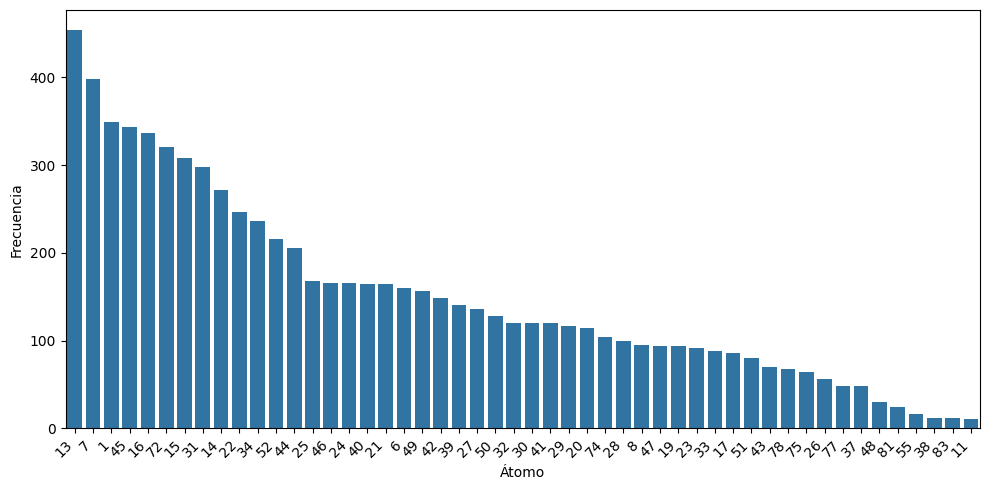

In [7]:
# Review unique atoms used in the dataset
counter = Counter(num for lista in data['atomic_numbers'] for num in lista)
counter_dict = dict(counter)
df_count = pd.DataFrame(list(counter_dict.items()), columns=['Átomo', 'Frecuencia'])
df_count['Átomo'] = df_count['Átomo'].apply(lambda x: int(x))
df_plot = df_count.sort_values(by='Frecuencia', ascending=False)
plt.figure(figsize=(10,5))
order = df_plot['Átomo']
sns.barplot(x='Átomo', y='Frecuencia',order=order, data=df_plot)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

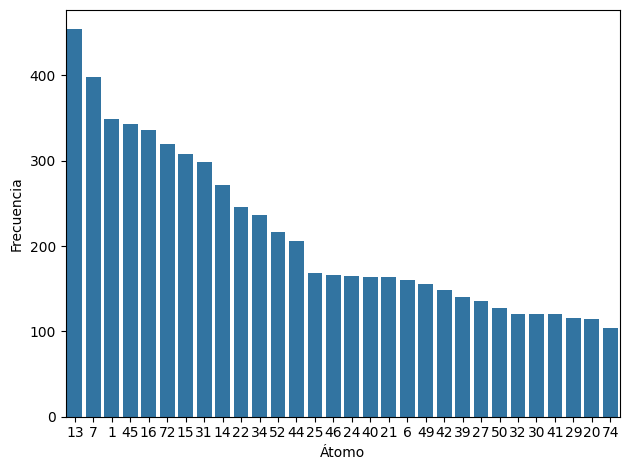

In [8]:
# view top 10 elements
df_plot = df_count.sort_values(by='Frecuencia', ascending=False)
df_plot = df_plot[df_plot['Frecuencia']>100]
order = df_plot['Átomo']
sns.barplot(x='Átomo', y='Frecuencia', order=order, data=df_plot)
plt.tight_layout()

In [9]:
 # Distribución de átomos en una sola estuctura
counter_atoms_structure = Counter(data.loc[0, 'atomic_numbers'])
df_plot_1structure = pd.DataFrame(
    list(dict(counter_atoms_structure).items()), 
    columns=['Elemento', 'Frecuencia']
    )


Text(0, 0.5, 'Elemento')

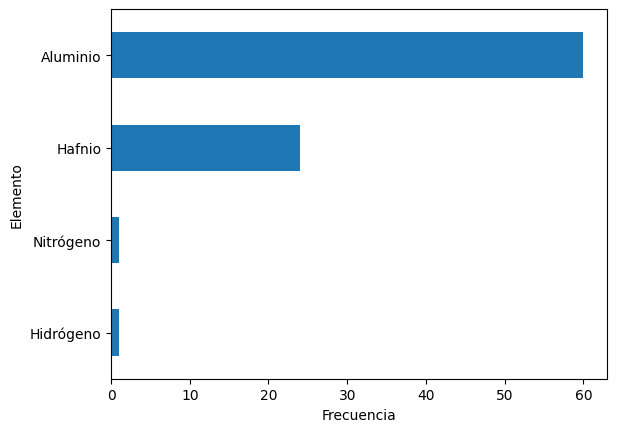

In [10]:
map = {1: 'Hidrógeno', 7:'Nitrógeno', 45:'Hafnio', 13:'Aluminio'}
df_plot_1structure.sort_values(by='Frecuencia', ascending=True, inplace=True)
df_plot_1structure['Elemento'] = df_plot_1structure['Elemento'].map(map)
df_plot_1structure.plot(kind='barh', x='Elemento', y='Frecuencia', legend=False)
plt.xlabel('Frecuencia')

plt.ylabel('Elemento')

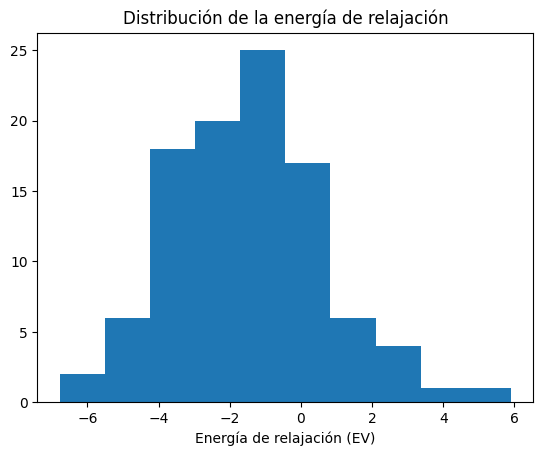

In [11]:
# relaxation energy ditribiution
data['y_relaxed'].hist()
plt.title('Distribución de la energía de relajación')
plt.xlabel('Energía de relajación (EV)')
plt.grid(False)

Distanve stats - Mean: 4.3685, std: 1.0727


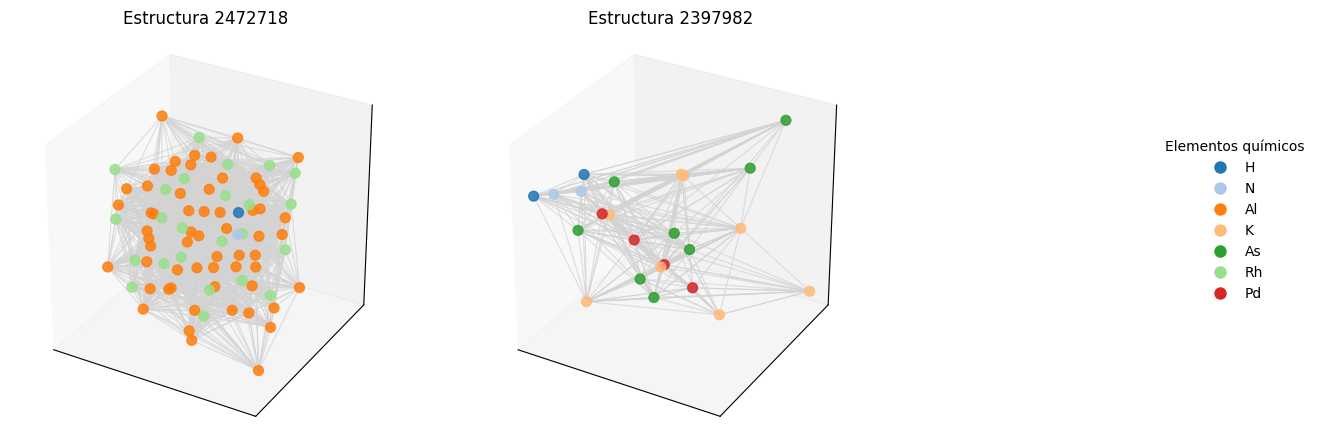

In [12]:
# Visualize structures
graph_data = AdvancedCatalystDataset(data)
# extract 4 graphs
graphs_list = [0, 82]
graphs = [graph_data[i] for i in graphs_list]
plot_graphs_pyg(graphs, max_cols=2)


## Completitud
Inicialmente no se tienen campos vacíos con excepción de las columnas x, edge_attr, norm y face, que están completamente vacías, por tanto se las puede eliminar del dataset.
## Unicidad
Del mismo modo, se encuentra que todas las estructuras importadas tienen un id de estructura distinto.
## Correlaciones
Se ha identificado que dentro del dataset se presenta una gran variedad de cantidad de átomos presentando en su mayoría estructuras con un número de átomos entre 60 y 80.
En este dataset se prueban aproximádamente varios elementos de la tabla periódica como el hidrógeno, Nitrógeno, Aluminio, Potasio, Arsénico, Rodio, Paladio, entre otros.

# Prueba de modelos, GCN convencional vs modelo Híbrido (GAT, GIN y Edge Gated)

In [13]:
# Define models
models = {
    'GCN': IS2RE_GCN(),
    'hybrid': hybrid()
}


In [14]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [ ]:
# define train and validation datasets
val = load_lmdb_data("../data/raw/is2res_train_val_test_lmdbs/data/is2re/all/val_id/data.lmdb", num_samples=None)
train = load_lmdb_data("../data/raw/is2res_train_val_test_lmdbs/data/is2re/all/train/data.lmdb", num_samples=None)
# turn datasets into graphs
val = AdvancedCatalystDataset(val)
train = AdvancedCatalystDataset(train)
# convert into data loaders
train_loader = DataLoader(train, batch_size=30, shuffle=True)
val_loader = DataLoader(val, batch_size=30, shuffle=False)

Distanve stats - Mean: 4.4156, std: 1.0695
Distanve stats - Mean: 4.4696, std: 1.0723


In [16]:
# train models
history = {
    'GCN': {},
    'hybrid': {}
}

for name, model in models.items():
    print(f'Training {name} model')
    history[name] = train_evaluate_epoch(model = models[name], 
                                         train_loader=train_loader, 
                                         val_loader=val_loader, 
                                         device=device)

Training GCN model

Starting training with scheduler and early stopping...


  -> New best validation MAE: 0.9509. Model saved.


  -> New best validation MAE: 0.9009. Model saved.


  -> New best validation MAE: 0.8726. Model saved.


  -> New best validation MAE: 0.8632. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.8371. Model saved.


  -> New best validation MAE: 0.8286. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.8210. Model saved.


  -> New best validation MAE: 0.8136. Model saved.


  -> New best validation MAE: 0.8111. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.8012. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.7972. Model saved.


  -> New best validation MAE: 0.7949. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.7905. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.7851. Model saved.


  -> New best validation MAE: 0.7845. Model saved.


  -> New best validation MAE: 0.7799. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


  -> No improvement in validation MAE for 6 epoch(s).


  -> New best validation MAE: 0.7585. Model saved.


  -> New best validation MAE: 0.7542. Model saved.


  -> New best validation MAE: 0.7541. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.7539. Model saved.


  -> New best validation MAE: 0.7537. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.7507. Model saved.


  -> New best validation MAE: 0.7463. Model saved.


  -> New best validation MAE: 0.7459. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.7440. Model saved.


  -> New best validation MAE: 0.7428. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


  -> No improvement in validation MAE for 6 epoch(s).


  -> New best validation MAE: 0.7312. Model saved.


  -> New best validation MAE: 0.7278. Model saved.


  -> New best validation MAE: 0.7259. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).
Training hybrid model

Starting training with scheduler and early stopping...


/usr/local/lib/python3.11/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


  -> New best validation MAE: 0.7664. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.6987. Model saved.


  -> New best validation MAE: 0.6812. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6675. Model saved.


  -> New best validation MAE: 0.6501. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> New best validation MAE: 0.6471. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6467. Model saved.


  -> New best validation MAE: 0.6437. Model saved.


  -> New best validation MAE: 0.6342. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6339. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6307. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6284. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> New best validation MAE: 0.6212. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


  -> No improvement in validation MAE for 6 epoch(s).


  -> New best validation MAE: 0.6118. Model saved.


  -> New best validation MAE: 0.6054. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


  -> No improvement in validation MAE for 6 epoch(s).


  -> New best validation MAE: 0.5995. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.5988. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> New best validation MAE: 0.5971. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


  -> No improvement in validation MAE for 6 epoch(s).


  -> New best validation MAE: 0.5920. Model saved.


  -> No improvement in validation MAE for 1 epoch(s).


  -> No improvement in validation MAE for 2 epoch(s).


  -> No improvement in validation MAE for 3 epoch(s).


  -> No improvement in validation MAE for 4 epoch(s).


  -> No improvement in validation MAE for 5 epoch(s).


Making predictions:   0%|          | 0/17 [00:00<?, ?it/s]

Making predictions: 100%|██████████| 17/17 [00:00<00:00, 36.32it/s]


Prediction results: MAE = 0.6159, RMSE = 0.9441


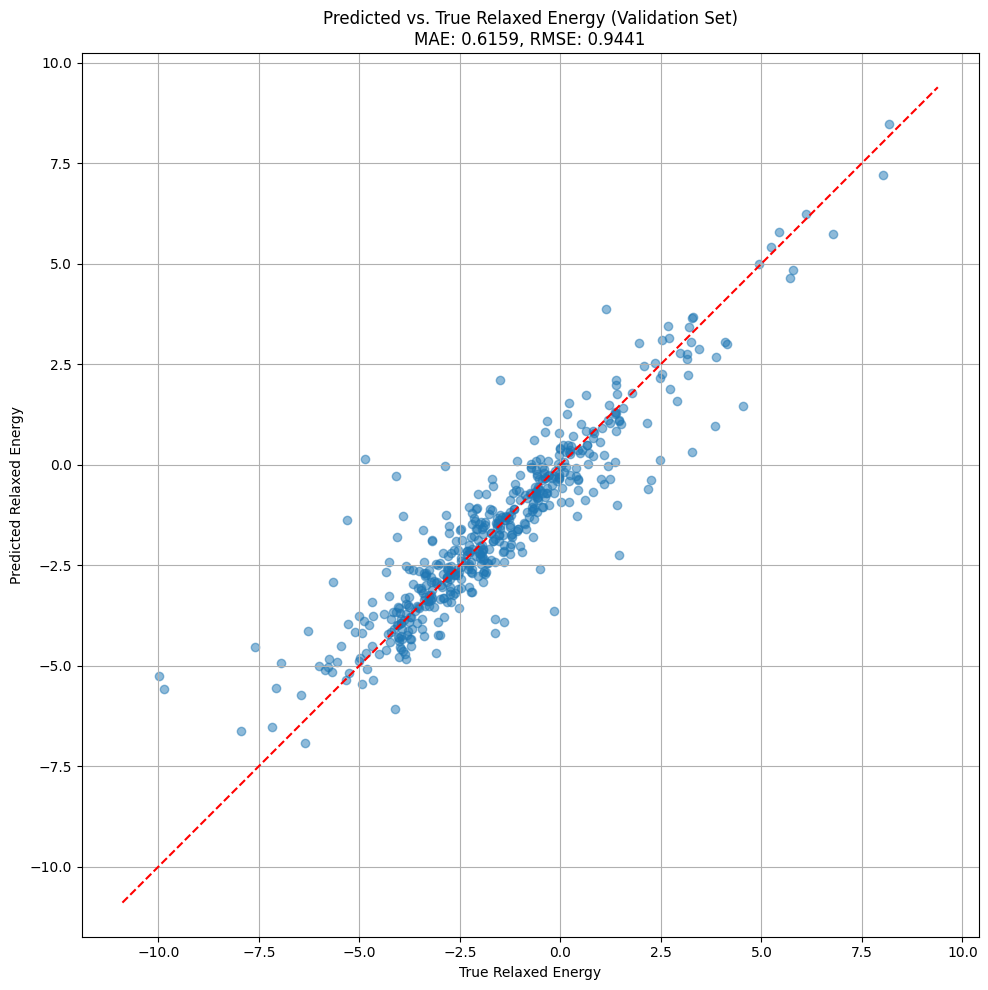

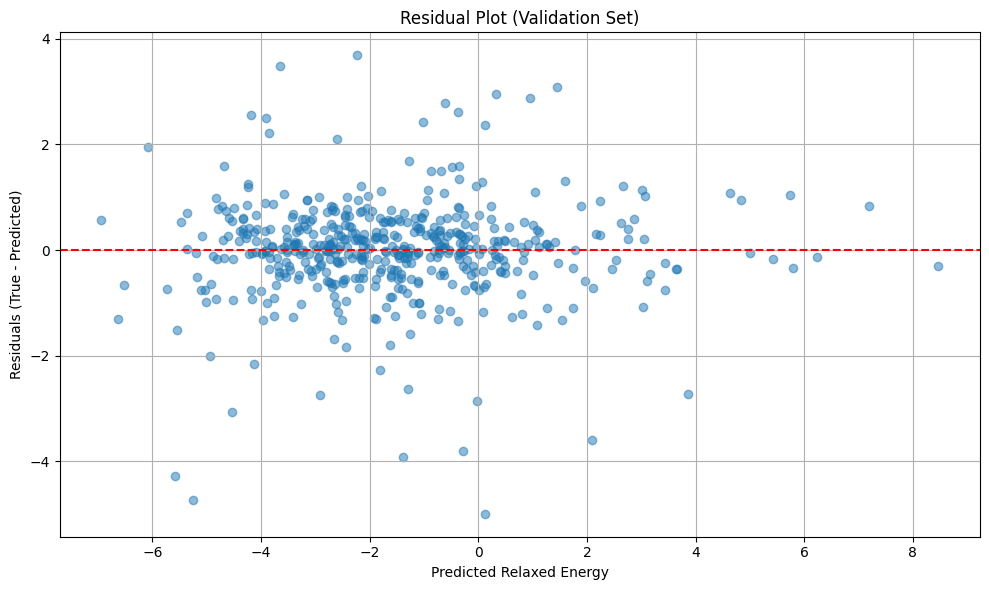

In [14]:
import torch
from helpers.utils import predict_and_visualize
from helpers.hibridmodel import hybrid
model = hybrid()
model.load_state_dict(torch.load('best_model.pt'))
predict_and_visualize(model, val_loader)
